# Projet Théorie d'apprentissage statistique

Ce projet consiste à mettre en valeur l'apprentissage de kernel de manière plus efficace, à travers : 

- Les Random features de Fourier pour remplacer les features de base
- Méthode de Nyströme pour l'approximation de la matrice de Gram


Nous commençons par importer les bibliothèques nécessaires, à savoir : Numpy et Scikit-learn 

In [40]:
import numpy as np
import pandas as pd 
from scipy import linalg
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

from sklearn.svm import SVC, LinearSVC
from sklearn.metrics.pairwise import rbf_kernel
from time import time

from scipy.sparse.linalg import svds
from scipy.linalg import svd
from scipy.sparse import csc_matrix
from numpy.linalg import multi_dot
from numpy.linalg import norm

from math import pi

Nous générons un jeu de données aléatoires sur lequel nous réalisons nos expériences : 

In [42]:
X, y = make_classification(n_samples=1000,n_features=50)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Normalisation 

In [43]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Features:", X_train.shape[1])
print("Training samples :", X_train.shape[0])
print("Test samples:", X_test.shape[0])


Features: 50
Training samples : 750
Test samples: 250


#### Gaussian RBF Kernel Support Vector Classifier

Nous commençons par faire un apprentissage supervisé à l'aide d'un SVM avec un kernel RBF : 

In [44]:
# Train
t0 = time()
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
print("Training took  %0.3fs" % (time() - t0))

Training took  0.020s


In [45]:
# Test
t1 = time()
y_pred = clf.predict(X_test)
timing_kernel = time() - t1
print("Evaluation took   %0.3fs" % (time() - t1))

Evaluation took   0.008s


In [46]:
# Accuracy
accuracy_kernel = accuracy_score(y_pred, y_test)
print("classification accuracy: %0.3f" % accuracy_kernel)

classification accuracy: 0.964



#### Utilities : 

Nous utilisons cette fonction de tracé de temps de fit et 'éval pour les algo dans notre benchmark 


In [47]:
def plot_time_complexity(clf, X, y, title):
    """
    Plot the time curve of a classifier
    :param clf: the classifier
    :param X: the entire training set
    :param y: the entire results column
    :param title: the title for the plot
    """
    training_percent = np.linspace(0.10, 0.9, 10)
    data = []
    for train in training_percent:
        test_pct = 1.0 - train
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_pct, random_state=0)
        t0 = time()
        clf.fit(X_train, y_train)
        t1 = time()
        t2 = time()
        clf.predict(X_test)
        t3 = time()
        times_fit = t1-t0
        times_pred = t3-t2
        data.append([train, times_fit, times_pred])
    data = np.asarray(data)
    train_sizes =data[:,0]
    train_times =data[:,1]
    pred_time = data[:,2]
    plt.plot(train_sizes, train_times, 'o-', color='r', label='Training ')
    plt.plot(train_sizes, pred_time, 'o-', color='g', label='Evaluation ')
    plt.xlabel('Training Set Size (%)')
    plt.ylabel('Time (s)')
    plt.title(title)
    plt.legend(loc='best')
    plt.show()
    


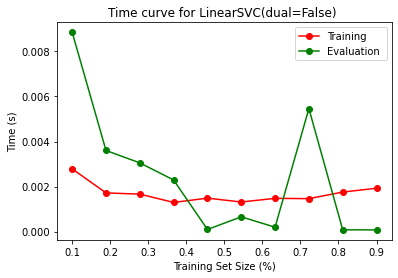

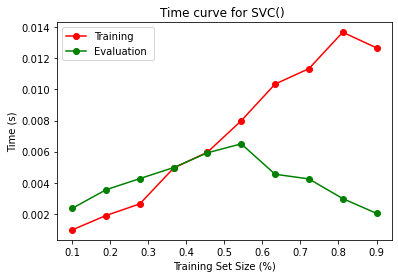

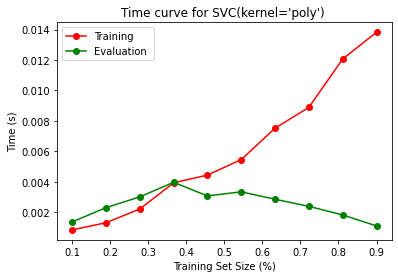

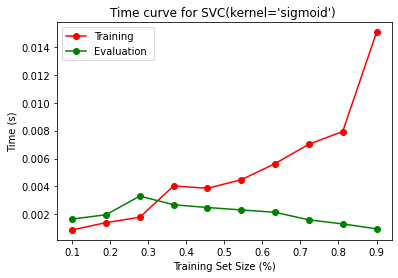

In [48]:
# Plot the time curve of various kernels on SVM
clf_array = [LinearSVC(dual=False),SVC(kernel='rbf'), SVC(kernel='poly'),SVC(kernel='sigmoid')]
for clf in clf_array:
    plot_time_complexity(clf, X_train, y_train,title =f"Time curve for {clf} ")
    

Nous constatons une augmentation de temps de calcul lorsqu'on utilise un kernel polynomiale par rapport aux autres kernels.  

## Multliple Kernel Learning : 

Nous considérons l'apprentissage de 5 kernels, nous notons les poids de pondération du kernel $\beta$ un vecteur de dimension 5.

On considère une combinaison de 5 kernels RBF.


In [49]:
def list_of_rbf_kernels(X,gamma1,gamma2,gamma3,gamma4,gamma5):
    
    K1 = rbf_kernel(X,X, gamma1)
    K2 = rbf_kernel(X,X, gamma2)
    K3 = rbf_kernel(X,X, gamma3)
    K4 = rbf_kernel(X,X, gamma4)
    K5 = rbf_kernel(X,X,gamma5)
    return [K1,K2,K3,K4,K5]


In [50]:
def mkl(X, y, gamma1,gamma2,gamma3,gamma4,gamma5, C = 0.3, maxiter =1000 , thresh = 1e-4 ):
    ##initialisation
    beta = np.ones(5)*1/5 ## 5 Kernels ====> 5 beta à approximer
    beta = np.expand_dims(beta, axis=1)
    alpha_old = np.zeros(X.shape[0]) ##alpha_total_anc :alpha_total_ancien
    
    #calcul du paramètre alpha
    
    Kernels = list_of_rbf_kernels(X,gamma1,gamma2,gamma3,gamma4,gamma5)
    print(len(Kernels))
    Kernels = np.expand_dims(Kernels, axis=1)
    cpt = 0
    # on fait l'optimisation d'une manière alternative,
    #une fois on trouve alpha, on fixe et on optimise  pour trouvez
    #beta et ainsi de suite 
    while cpt < maxiter:
        print(cpt)
        Kernels = Kernels[:,0, :, :]
        K = np.matmul(beta.T,Kernels)
        print("k shape" , Kernels.shape)
        #K = beta[0]*K_1 + beta[1]*K_2 + beta[2]*K_3 + beta[3]*K_4
        alpha_new = np.linalg.inv( K + C*np.eye(X.shape[0]))@y ## alpha =([K+C*I]^-1)Y
        if np.linalg.norm(alpha_new - alpha_old) < thresh: 
            print("On converge vers un minimum local pour alpha ")
            break
        f_k = []
        for i in range(len(beta)):
            f_k.append(alpha_new.T@Kernels[i]@alpha_new)
        
        for i in range(len(d_k_list)):
            beta[i] = ((np.linalg.norm(f_k_list[i]))**(2/(r+1)) )/( (np.sum( np.array(f_k_list)**(2*r/(r+1)) ))**(1/r) )
        
        alpha_old = alpha_new #maj de  alpha
        cpt += 1
        
    return beta, alpha_old, K 

#### Limitations  : 

Si on jette un coup d'oeil sur la matrice Gramm, nous pouvons observer que l'entrainement se fait en $O(N^2)$, ce qui rend les calculs infaisables dans le cas où le nombre d'échantillons est très grand.






$$K = \begin{pmatrix} K(X_1, X_1) & K(X_1, X_2) & .. & K(X_1, X_n) \\ ... & ... & ... & ... \\ K(X_n, X_1) & K(X_n, X_2) & .. & K(X_n, X_n) \end{pmatrix}$$

Afin de détourner ces problèmes nous introduisons : 

- Random Fourier features: Permet d'approximer la fonction kernel 
- Nyström approximation: Permet d'approximer la matrice de Gramm.

## Random Fourier features


L'idée de Random Fourier Features est de trouver une fonction de mapping de dimension finie $\hat{\phi}(X) \in \mathbb{R}^c$.

$$
K(X, X') ≈ < \hat{\phi}(X), \hat{\phi}(X') >
$$

In [51]:
def random_features(X_train, X_test, gamma, c, seed=500):
    rng = np.random.RandomState(seed)
    m, n = X_train.shape
    
    Q = rng.randn(n, c)
    b = rng.rand(1, c) * 2 * np.pi

    X_train = np.sqrt(2 / c) * np.cos(X_train @ Q + b)
    X_test = np.sqrt(2 / c) * np.cos(X_test @ Q + b )

    X_train_new = np.exp(-gamma * (2 * X_train @ X_train.T - 1))
    X_test_new = np.exp(-gamma * (2 * X_test @ X_train.T - 1))
    return X_train_new, X_test_new

In [52]:
gamma = 0.05

In [53]:
X_train_Fourier, X_test_Fourier = random_features(X_train, X_test, gamma, c=100)

#### SVM avec kernel rbf sur les Random Features : 

In [54]:
t0 = time()
clf = SVC(kernel='rbf')
clf.fit(X_train_Fourier, y_train)
print("Training took %0.3fs" % (time() - t0))

Training took 0.197s


In [55]:
t1 = time()
accuracy = clf.score(X_test_Fourier, y_test)
print("Evaluation took  %0.3fs" % (time() - t1))
print("classification accuracy: %0.3f" % accuracy)

Evaluation took  0.123s
classification accuracy: 0.496


#### Linear SVM  sur les Random Features : 

In [56]:
t0 = time()
clf = LinearSVC(dual=False)
clf.fit(X_train_Fourier, y_train)
print("Training took in %0.3fs" % (time() - t0)) 

Training took in 0.074s


Trop rapide par rapport au SVM avec rbf kernel. 

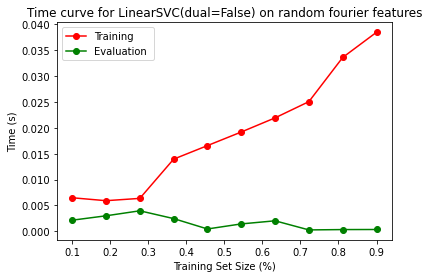

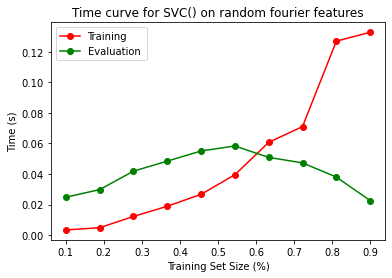

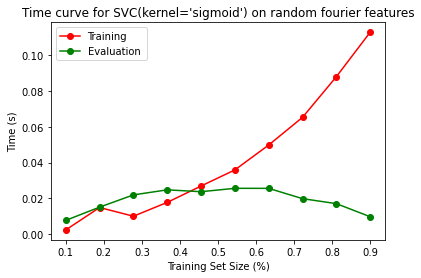

In [57]:
clf_array = [LinearSVC(dual=False),SVC(kernel='rbf'),SVC(kernel='sigmoid')]
for clf in clf_array:
    plot_time_complexity(clf, X_train_Fourier, y_train,title =f"Time curve for {clf} on random fourier features")
   

## Discussion : 


Nous comparons les résultats obtenues sur les Random Fourier Features et sur nos features de base.

Pour les algorithmes où nous utilisons le kernel ça devien t extremement long, et surtout pour le kernel poly.

L'accuracy obtenue sur les Random Fourier Features est très proche de celle obtenue sur les features de base.
Le temps de training ou même de prédiction est considérablement bas par rapport à la première manipulation.

## Nystrom Approximation

La méthode de Nystrom consiste à approximer la matrice de Gramm, en passant par une SVD de cette matrice .


On considère que la matrice est de rang $m$, alors on peut la décomposer en SVD, et plus précisement : 

$$
K = U A U^T
$$

Où U contient les vecteurs propres et de taille $n\times m$, les valeurs propres dans $A$ de taille $m\times m$.

In [58]:
def nystrom(X_train, X_test, gamma, c, k, seed=500):

    rng = np.random.RandomState(seed) # pour des soucis de reproduction de résultats je fixe le seed utilisé.
    n_samples = X_train.shape[0]
    idx = rng.choice(n_samples, c) #choix d'indices alétaoires 

    X_train_idx = X_train[idx, :] 
    W = rbf_kernel(X_train_idx, X_train_idx, gamma=gamma) # matrice kernel 

    u, s, vt = linalg.svd(W, full_matrices=False) # svd
    u = u[:,:k] #truncate vecteurs propres
    s = s[:k]
    vt = vt[:k, :]

    M = np.dot(u, np.diag(1/np.sqrt(s))) 

    C_train = rbf_kernel(X_train, X_train_idx, gamma=gamma) #K(X,X_i)
    C_test = rbf_kernel(X_test, X_train_idx, gamma=gamma)

    X_new_train = np.dot(C_train, M)     #X_new = C*M 
    X_new_test = np.dot(C_test, M)

    return X_new_train, X_new_test

In [59]:
gamma = 0.05

In [60]:
X_train_nystrom, X_test_nystrom = nystrom(X_train, X_test, gamma, c=500, k=300, seed=500)

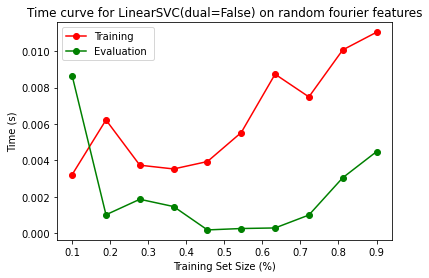

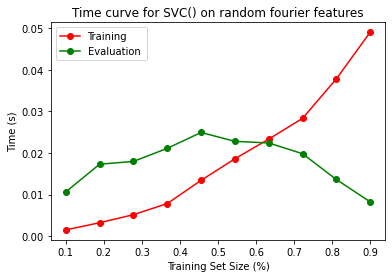

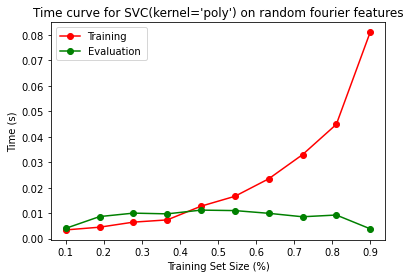

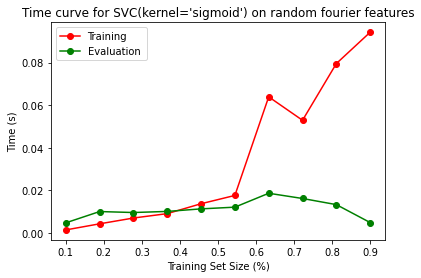

In [61]:
clf_array = [LinearSVC(dual=False),SVC(kernel='rbf'), SVC(kernel='poly'),SVC(kernel='sigmoid')]
for clf in clf_array:
    plot_time_complexity(clf, X_train_nystrom, y_train,title =f"Time curve for {clf} on random fourier features")
   

Nous constatons au final que les deux approches pour réduire la complexité de calcul donne des performances très proches de celles obtenues à base des données réelles.

Pour mieux voire l'effet des méthodes d'approximation, nous recommandons l'utilisation d'augmenter le nombre d'échantillons.